In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdd import rdd

In [2]:
np.random.seed(42)
N = 10000
x = np.random.normal(1, 1, N)
epsilon = np.random.normal(0, 1, N)

# threshold is the 'cutoff' point
threshold = 1
treatment = np.where(x >= threshold, 1, 0)
w1 = np.random.normal(0, 1, N)
w2 = np.random.normal(0, 4, N)
y = .5 * treatment + 2 * x - .2 * w1 + 1 + epsilon


# X is the (time) that has a cutoff
# y is the corresponding responses
# w1, w2 are other variables
data = pd.DataFrame({'y':y, 'x': x, 'w1':w1, 'w2':w2})
data.head()

,y,x,w1,w2
0,3.745276,1.496714,0.348286,-7.922288
1,2.361307,0.861736,0.283324,-4.219943
2,4.385300,1.647689,-0.936520,-2.348114
3,6.540561,2.523030,0.579584,0.598676
4,4.026888,0.765847,-1.490083,4.096649


### Find the best bandwidth around the threshold (cutoff point)

In [3]:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 0.7448859965965812


### Preserve the data with 'x' within bandwidth of the cutoff point

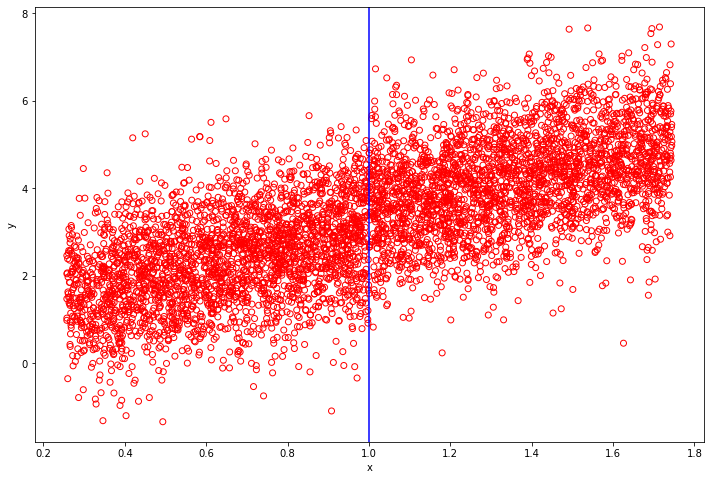

In [5]:
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)
# directly plot the datapoints

plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['x'], data_rdd['y'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

In [13]:
data_rdd.head()

,y,x,w1,w2
0,3.745276,1.496714,0.348286,-7.922288
1,2.361307,0.861736,0.283324,-4.219943
2,4.385300,1.647689,-0.936520,-2.348114
4,4.026888,0.765847,-1.490083,4.096649
5,1.891521,0.765863,-0.654184,2.776544


### To better visualize, put data into bins (here 100 bins in total) and compute the mean

In [9]:
data_binned = rdd.bin_data(data_rdd, 'y', 'x', 100)
data_binned.head()

,0,y,x,n_obs
0,0.0,1.771719,0.264949,49.0
1,0.0,1.630716,0.279819,39.0
2,0.0,1.546218,0.294690,43.0
3,0.0,1.548439,0.309561,36.0
4,0.0,1.324685,0.324432,40.0


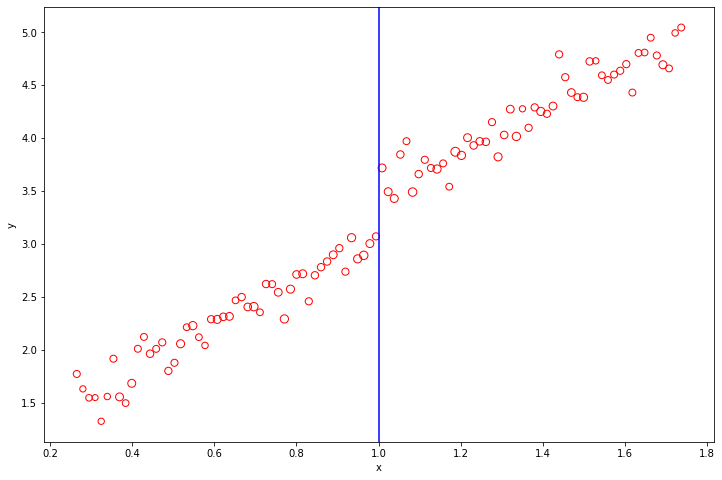

In [10]:
plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close()

# Estimation

Here the effect of the 'cutoff' event can be estimated using different formulas. The formulas can be specified in the class 'rdd'. In the following case, we use the regression y ~ TREATED + x. Here TREATED=1 if x >= cut, and 0 otherwise.

In [11]:
# estimate the model directly
# treatment = 1 if x>=threshold
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            WLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     2811.
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:20:31   Log-Likelihood:                -7794.0
No. Observations:                5442   AIC:                         1.559e+04
Df Residuals:                    5439   BIC:                         1.561e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

This example includes other variables and interaction w1*w2

In [12]:
model = rdd.rdd(data_rdd, 'x', cut=threshold, equation='y ~ TREATED + x + w1*w2')
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1*w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            WLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1194.
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:21:35   Log-Likelihood:                -7709.6
No. Observations:                5442   AIC:                         1.543e+04
Df Residuals:                    5436   BIC:                         1.547e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

This example involves interaction x*TREATED and allows different coefficients of x before and after the event.

In [14]:
model = rdd.rdd(data_rdd, 'x', cut=threshold, equation='y ~ TREATED + x + x*TREATED')
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + x*TREATED
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            WLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1874.
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:22:25   Log-Likelihood:                -7793.7
No. Observations:                5442   AIC:                         1.560e+04
Df Residuals:                    5438   BIC:                         1.562e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In